In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../src/scenes/')
import syndiff as sd 

from copy import deepcopy
from scipy.ndimage import rotate
import matplotlib.patches as patches
from matplotlib.path import Path

from scipy.optimize import minimize
from astropy.stats import sigma_clipped_stats
from glob import glob
from correct_saturation import saturated_stars, _get_bsc, SkyCoord, image2counts, query_ps1
from astropy.io import fits
from astropy.wcs import WCS
import tessreduce as tr
from PRF import TESS_PRF

from photutils.aperture import CircularAperture, CircularAnnulus,RectangularAperture
from photutils.aperture import ApertureStats, aperture_photometry

from correct_saturation import ps_psf, psf_minimizer, minimize,PS1_to_TESS_mag
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting

In [2]:
ps1_files = glob('data/star_field/*v.satcor.fits')
#ps1_files = glob('data/vega/*v.fits')
hdu = fits.open(ps1_files[1])
header = hdu[0].header

data = image2counts(hdu[0].data,header)
wcs = WCS(header)

In [3]:
ps1 = {}
cor = []
for file in ps1_files:
    hdu = fits.open(file)
    header = hdu[0].header

    data = image2counts(hdu[0].data,header)
    m,med,std = sigma_clipped_stats(data)
    ps1[file.split('stk.')[1].split('.unconv')[0]] = data-med
    cor += [header['FLUXFACT']]
cor = np.array(cor)

In [97]:
dec

array(45.36555112)

In [5]:
ra,dec = wcs.all_pix2world(data.shape[1]/2,data.shape[0]/2,0)
x,y = wcs.all_world2pix(ra,dec,0)

In [6]:
tess = tr.tessreduce(ra=ra,dec=dec,sector=20,calibrate=True,plot=False)
cat = query_ps1(ra,dec,0.4)
px,py = wcs.all_world2pix(cat.raMean,cat.decMean,0)
cat['ps1x'] = px; cat['ps1y'] = py
tx,ty = tess.wcs.all_world2pix(cat.raMean,cat.decMean,0)
cat['tessx'] = tx; cat['tessy'] = ty
cat = PS1_to_TESS_mag(cat)

getting TPF from TESScut
made reference
made source mask
calculating background
background subtracted
aligning images
!!Re-running for difference image!!
shifting images
remade mask
background
background correlation correction
field calibration
target is above -30 dec, calibrating to PS1 photometry.


In [7]:
PSF = TESS_PRF(tess.tpf.camera,tess.tpf.ccd,20,tess.tpf.row+45, tess.tpf.column + 4)
psf = PSF.locate(6,6)
scale = 21/0.25
x = np.arange(0,psf.shape[0],1)+0.5
y = np.arange(0,psf.shape[1],1)+0.5
x2 = np.arange(0,psf.shape[0], 1/scale)
y2 = np.arange(0,psf.shape[1], 1/scale)

In [8]:
func = sd.RectBivariateSpline(x,y,psf)
psf = func(x2,y2)
psf /= np.nansum(psf)

In [9]:
g_init = models.Gaussian2D()
fit_g = fitting.LevMarLSQFitter()
y, x = np.mgrid[:psf.shape[0], :psf.shape[1]]
x = x-psf.shape[1]/2; y =y- psf.shape[0]/2
g = fit_g(g_init, x, y, psf)

In [10]:
x0 = [50,50,0,0,0,0]
res = minimize(psf_minimizer,x0,args=(psf,x,y))
pspsf= ps_psf(res.x[:-2],x-res.x[-2],y-res.x[-1])

In [11]:
g

<Gaussian2D(amplitude=0.00003465, x_mean=1.16040097, y_mean=2.00356724, x_stddev=64.62029598, y_stddev=61.98585639, theta=6.84225161)>

In [12]:
y, x = np.mgrid[:psf.shape[0], :psf.shape[1]]
x = x-psf.shape[1]/2; y =y- psf.shape[0]/2
psfg = models.Gaussian2D(x_stddev=25,y_stddev=25)
psfg = psfg(x,y)
psfg /= np.nansum(psfg)

<IPython.core.display.Javascript object>


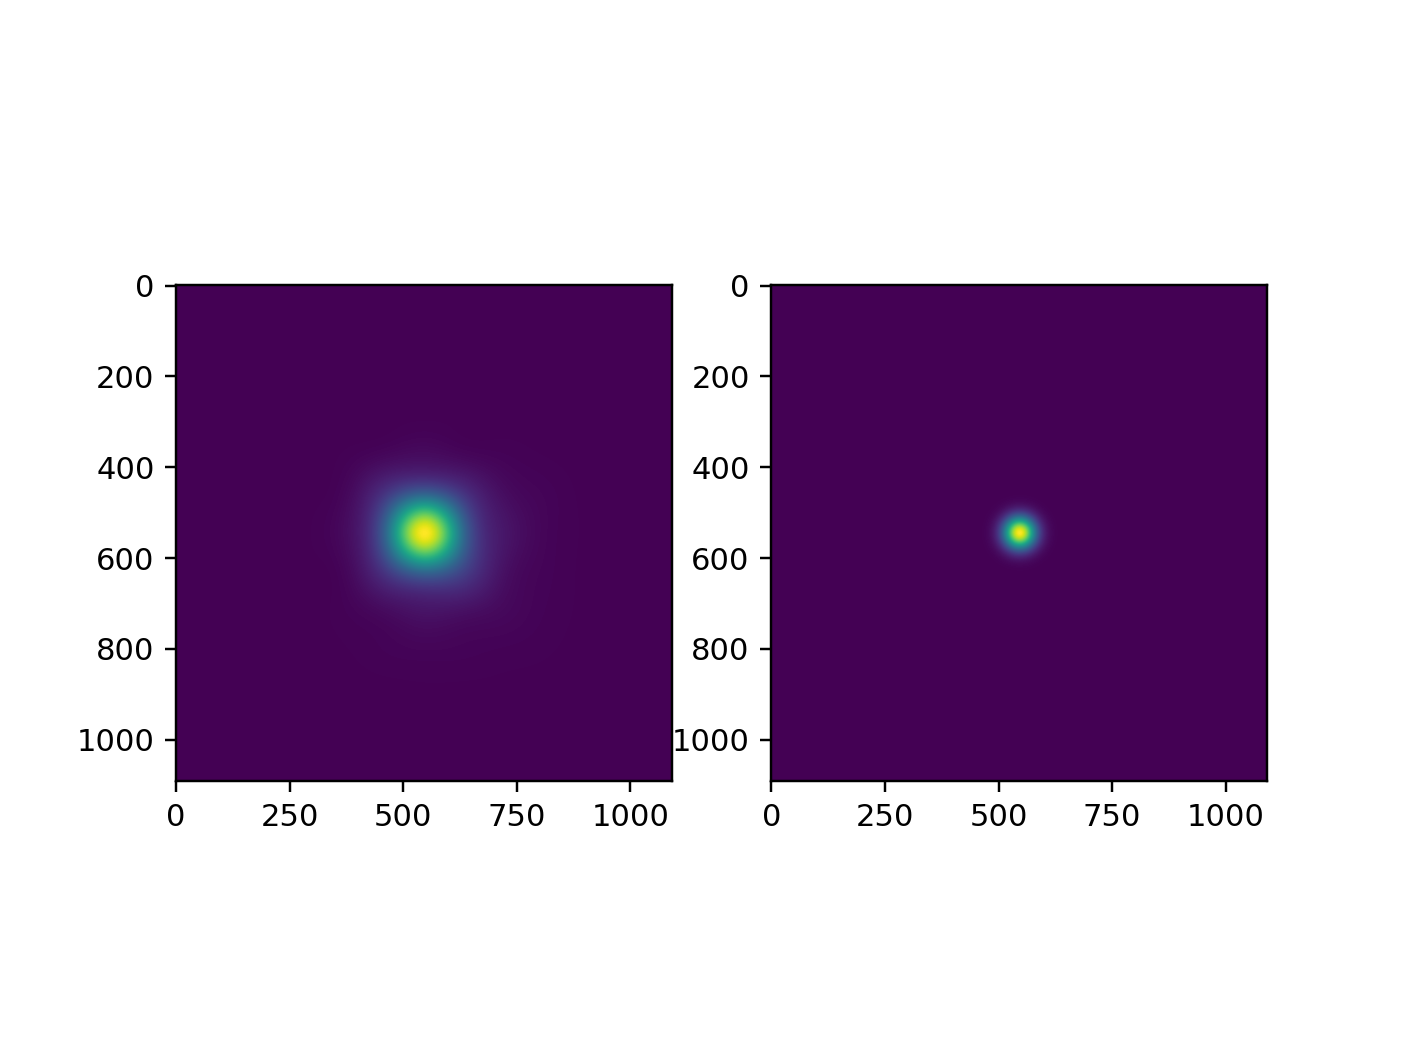

In [13]:
plt.figure()
plt.subplot(121)
plt.imshow(psf)
plt.subplot(122)
plt.imshow(psfg)

In [14]:
conv = deepcopy(ps1)
for key in list(ps1.keys()):
    conv[key][np.isnan(conv[key])] = 0
    conv[key] = sd.signal.fftconvolve(conv[key], psfg, mode='same')

ps1_tess = 0.238*conv['r'] + 0.344*conv['i'] + 0.283*conv['z'] + 0.135*conv['y']
noconvps1_tess = 0.238*ps1['r'] + 0.344*ps1['i'] + 0.283*ps1['z'] + 0.135*ps1['y']

In [15]:
sub = cat.loc[(cat.iMeanPSFMag < 17) ]# & (cat.rMeanPSFMag > 12)
#sub = cat.loc[(cat.tmag < 14) & np.isfinite(cat.tmag)  & (cat.rMeanPSFMag > 14)]
ind = ((sub.ps1x.values>100) & (sub.ps1x.values<ps1_tess.shape[1]-100) & 
       (sub.ps1y.values>100) & (sub.ps1y.values<ps1_tess.shape[0]-100) & 
       (sub.tessy.values>0) & (sub.tessy.values<tess.ref.shape[0]) &
       (sub.tessx.values>0) & (sub.tessx.values<tess.ref.shape[1]))

sub = sub.loc[ind]

subsub = sub.iMeanPSFMag.values >14

In [16]:
ap_size = 2
pos = list(zip(sub.tessx, sub.tessy))
taperture = CircularAperture(pos, ap_size)
a = tess.tpf.flux.value[tess.ref_ind]
m,med,std = sigma_clipped_stats(a)
tphot_table = aperture_photometry(a-med, taperture)
#tphot_table = aperture_photometry(tess.ref, taperture)

pos = list(zip(sub.ps1x, sub.ps1y))
paperture = CircularAperture(pos, ap_size*scale)
pphot_table = aperture_photometry(ps1_tess, paperture)
aperture = CircularAperture(pos, 20)
ncpphot_table = aperture_photometry(noconvps1_tess, aperture)

ptmag = -2.5*np.log10(pphot_table['aperture_sum'].value)
ncptmag = -2.5*np.log10(ncpphot_table['aperture_sum'].value)
tmag = -2.5*np.log10(tphot_table['aperture_sum'].value)
ind = np.isfinite(tmag) & np.isfinite(ptmag)

ptmag = ptmag[ind]
tmag = tmag[ind] + tess.zp
ncptmag = ncptmag[ind]

<IPython.core.display.Javascript object>


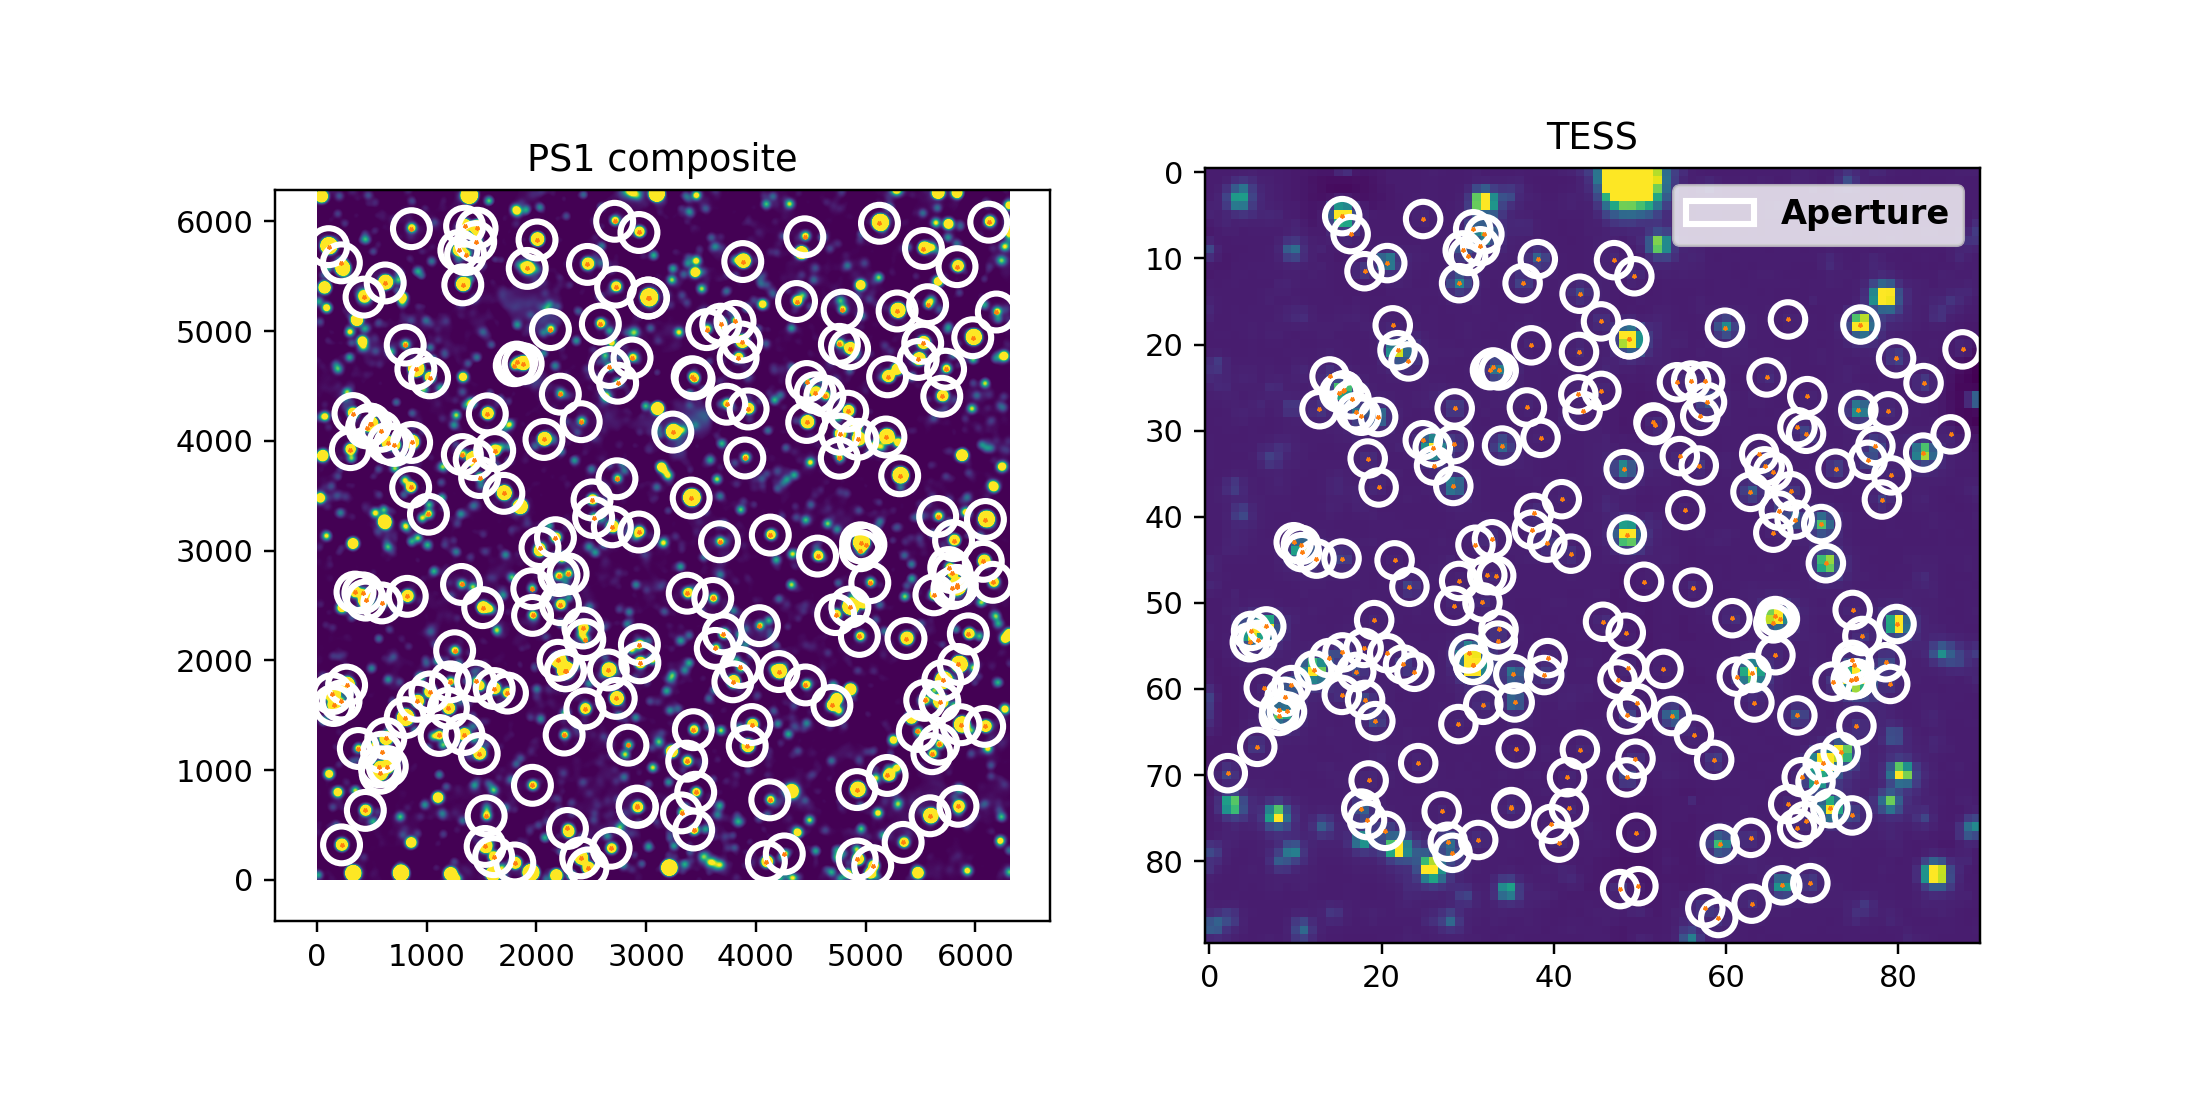

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('PS1 composite')
plt.imshow(ps1_tess,vmin=0,vmax=5e2,origin='lower')
plt.plot(sub.ps1x,sub.ps1y,'C1*',ms=1)
ap_patches = paperture.plot(color='white', lw=2,
                           label='Photometry aperture')


plt.subplot(122)
plt.subplot(122)

plt.title('TESS')
plt.imshow(tess.ref,vmax=5e2)
plt.plot(sub.tessx,sub.tessy,'C1*',ms=1)
ap_patches = taperture.plot(color='white', lw=2,
                           label='Aperture')

handles = ([ap_patches[0]])
plt.legend(loc=1,
           handles=handles, prop={'weight': 'bold', 'size': 11})

In [18]:
subsub = (tmag >13.5) & (tmag < 15)
fit = fitting.LinearLSQFitter()

# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=3.0)

# initialize a linear model
line_init = models.Linear1D(slope=1,fixed={'slope': True})
line_flexi = models.Linear1D(slope=1)

# fit the data with the fitter
fitted_line, mask = or_fit(line_init, tmag[subsub], ptmag[subsub])
flexi_line, mask = or_fit(line_flexi, tmag[subsub], ptmag[subsub])
filtered_data = np.ma.masked_array(ptmag[subsub], mask=mask)

<IPython.core.display.Javascript object>


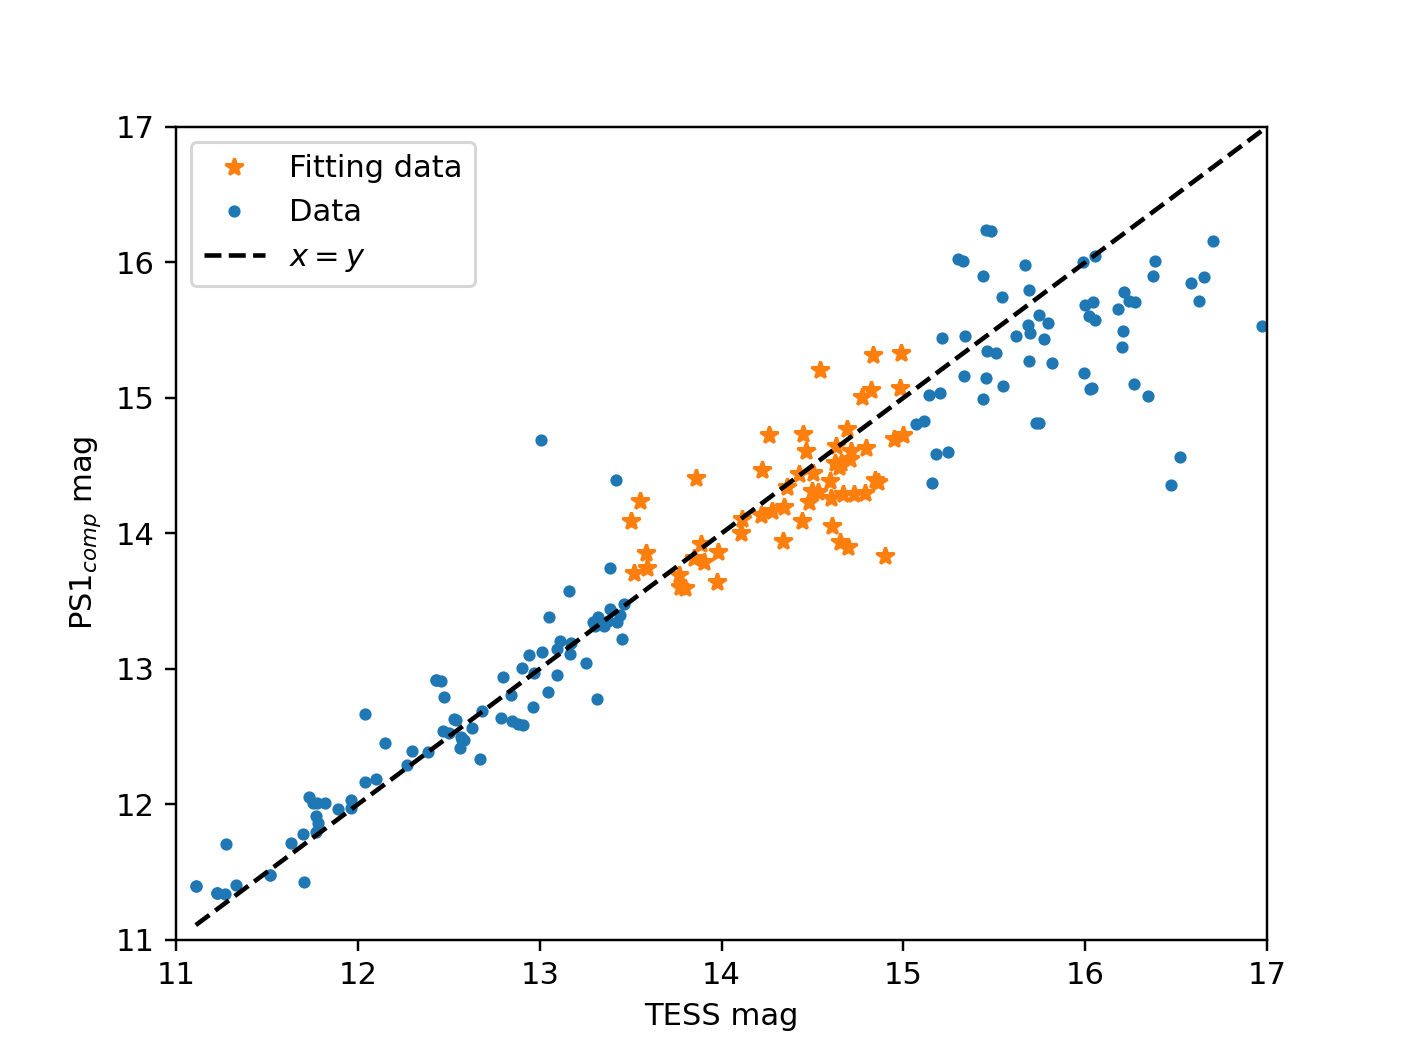

In [19]:
x = np.arange(min(tmag),max(tmag))
plt.figure()
plt.plot(tmag[subsub], filtered_data - fitted_line.parameters[1], "C1*", label="Fitting data")
#plt.plot(tmag, ptmag,"C1o", fillstyle="none", label="Clipped")
plt.plot(tmag[~subsub], ptmag[~subsub] - fitted_line.parameters[1], "C0.", label="Data")
plt.plot(x, fitted_line(x)- fitted_line.parameters[1], 'k--', label=r'$x=y$')
#plt.plot(x,flexi_line(x)- fitted_line.parameters[1],'C1--', label=f'Model, m={np.round(flexi_line.parameters[0],2)}')
plt.xlabel('TESS mag')
plt.ylabel(r'PS1$_{comp}$ mag')
plt.xlim(11,17)
plt.ylim(11,17)
plt.legend()
plt.savefig('ps1_tess_magcomparison.png')


<IPython.core.display.Javascript object>


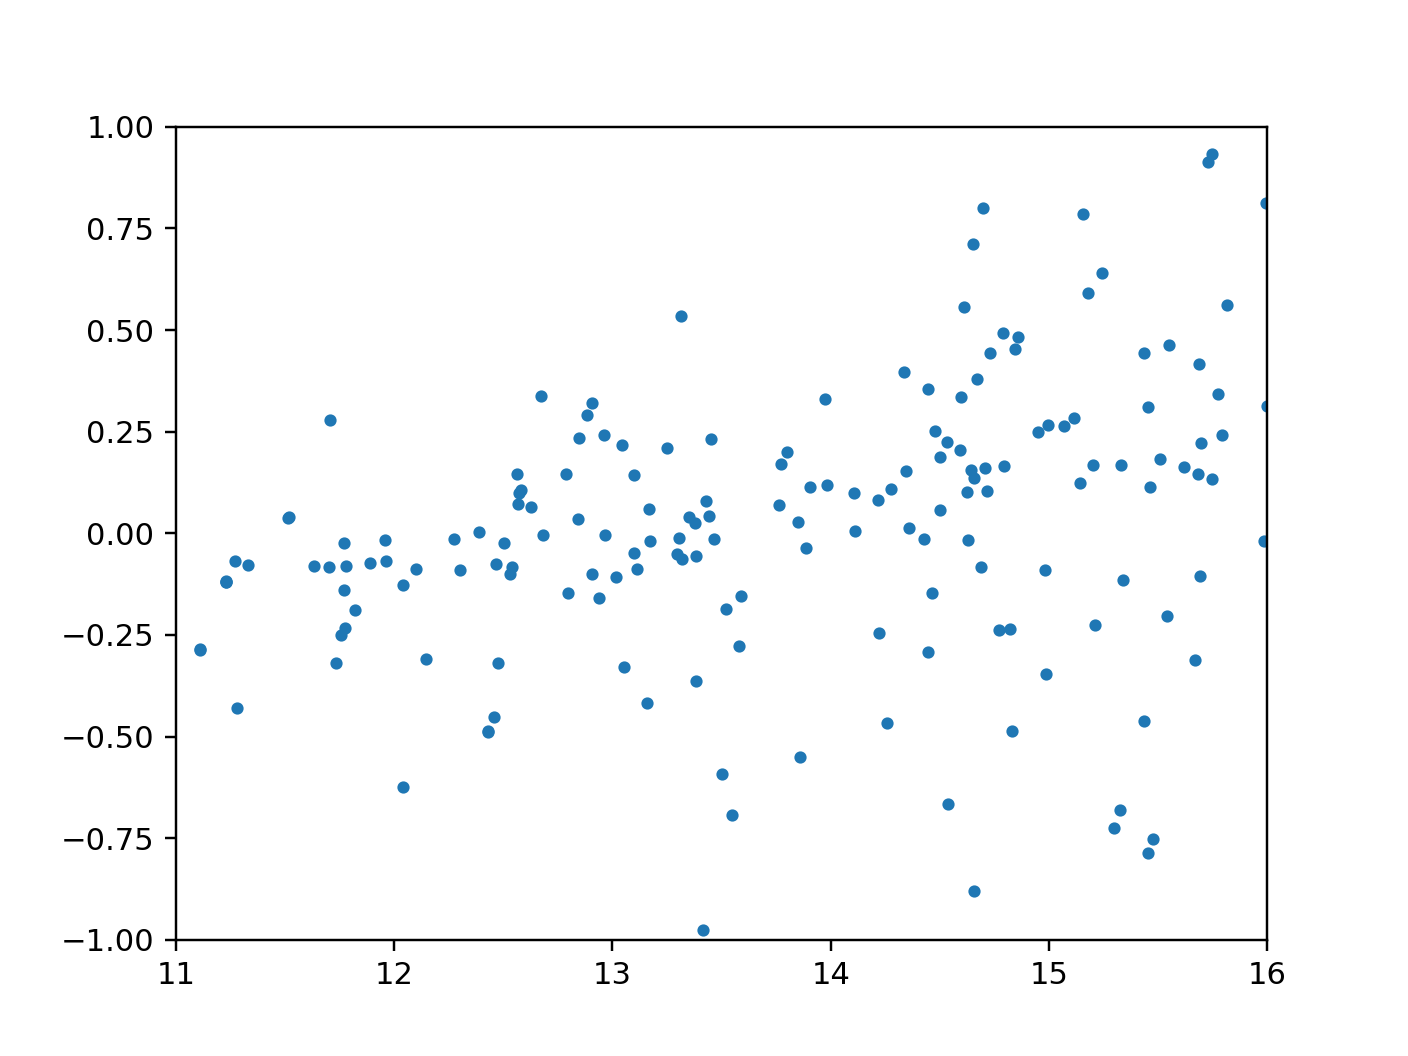

(11.0, 16.0)

In [20]:
plt.figure()
plt.plot(tmag,tmag-ptmag+fitted_line.parameters[1],'.')
plt.ylim(-1,1)
plt.xlim(11,16)

<IPython.core.display.Javascript object>


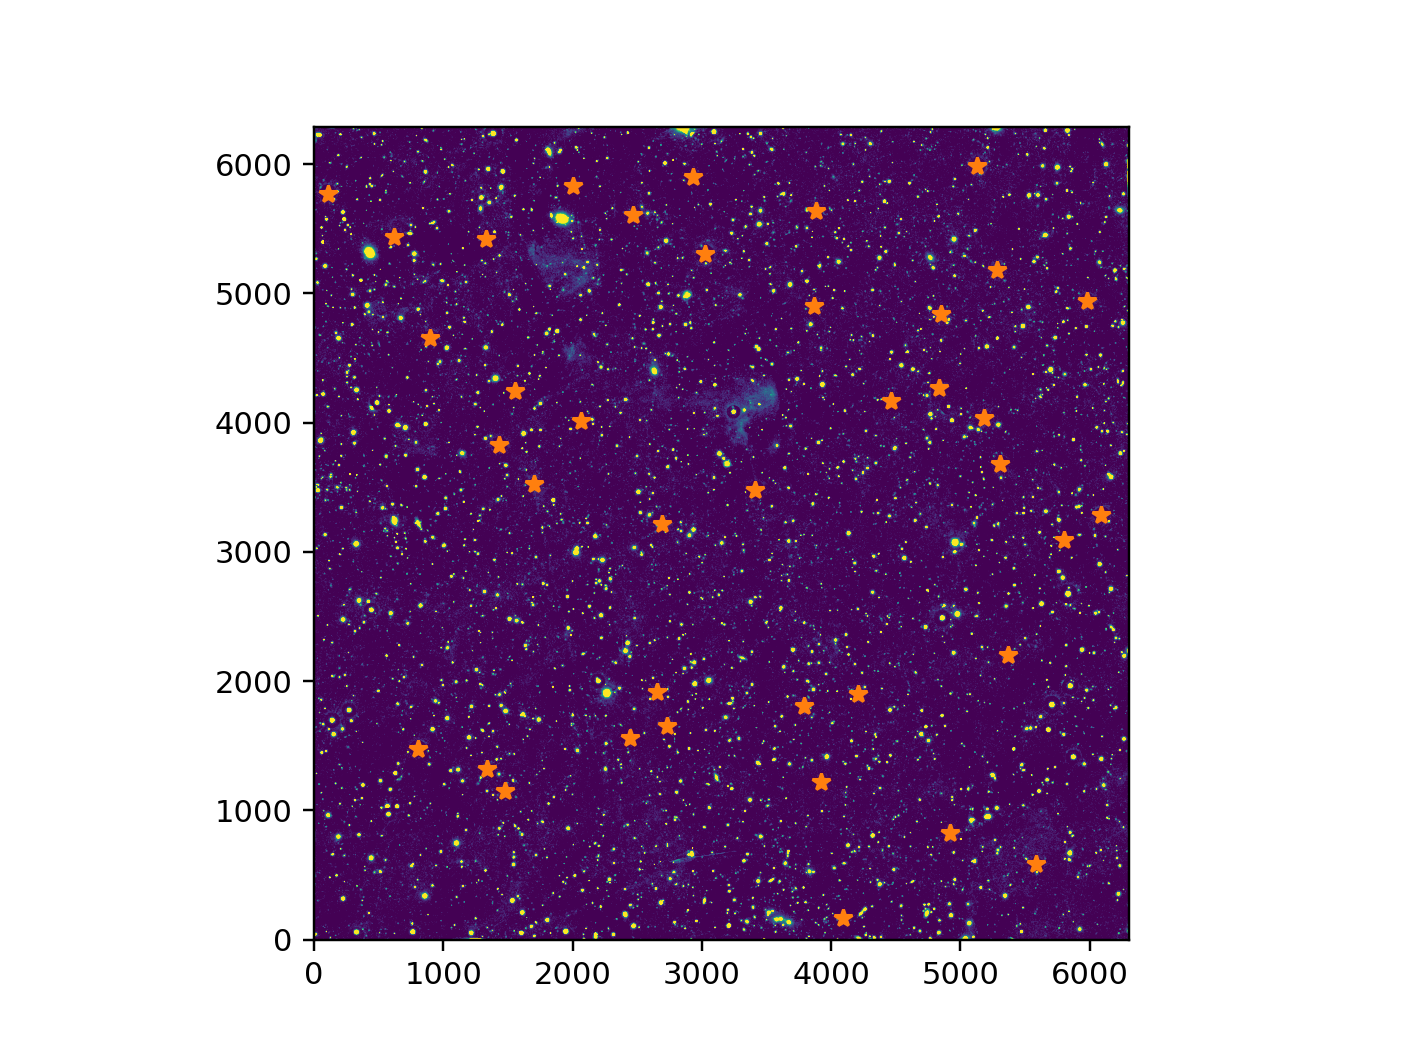

In [185]:
ind = abs(tmag-sub.tmag.values) < 0.1
plt.figure()
plt.imshow(noconvps1_tess,vmin=0,vmax=5e2,origin='lower')
plt.plot(sub.ps1x.values[ind],sub.ps1y.values[ind],'C1*')

<IPython.core.display.Javascript object>


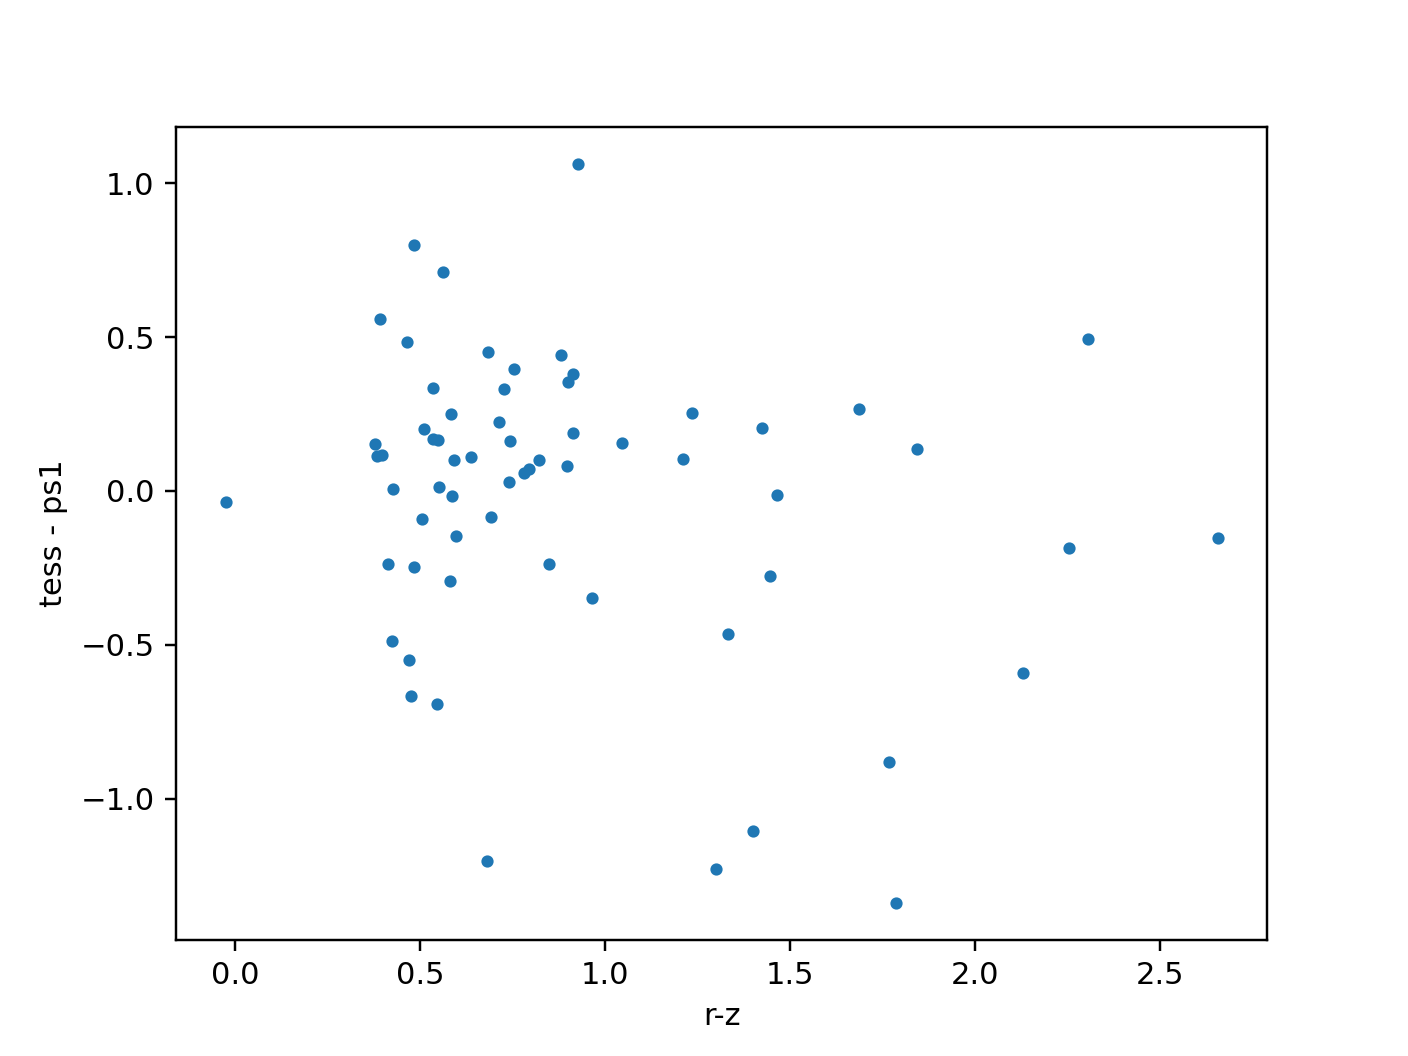

Text(0, 0.5, 'tess - ps1')

In [25]:
gi = (sub.gMeanPSFMag.values - sub.iMeanPSFMag.values)[ind][subsub]
plt.figure()
plt.plot(gi,(tmag-ptmag)[subsub]+fitted_line.parameters[1],'.')
plt.xlabel('r-z')
plt.ylabel('tess - ps1')

In [274]:
len(ptmag)

211

In [280]:
20.44 + np.nanmedian(ncptmag-sub.tmag.values[ind] - fitted_line.parameters[1])

20.28416760710141

<IPython.core.display.Javascript object>


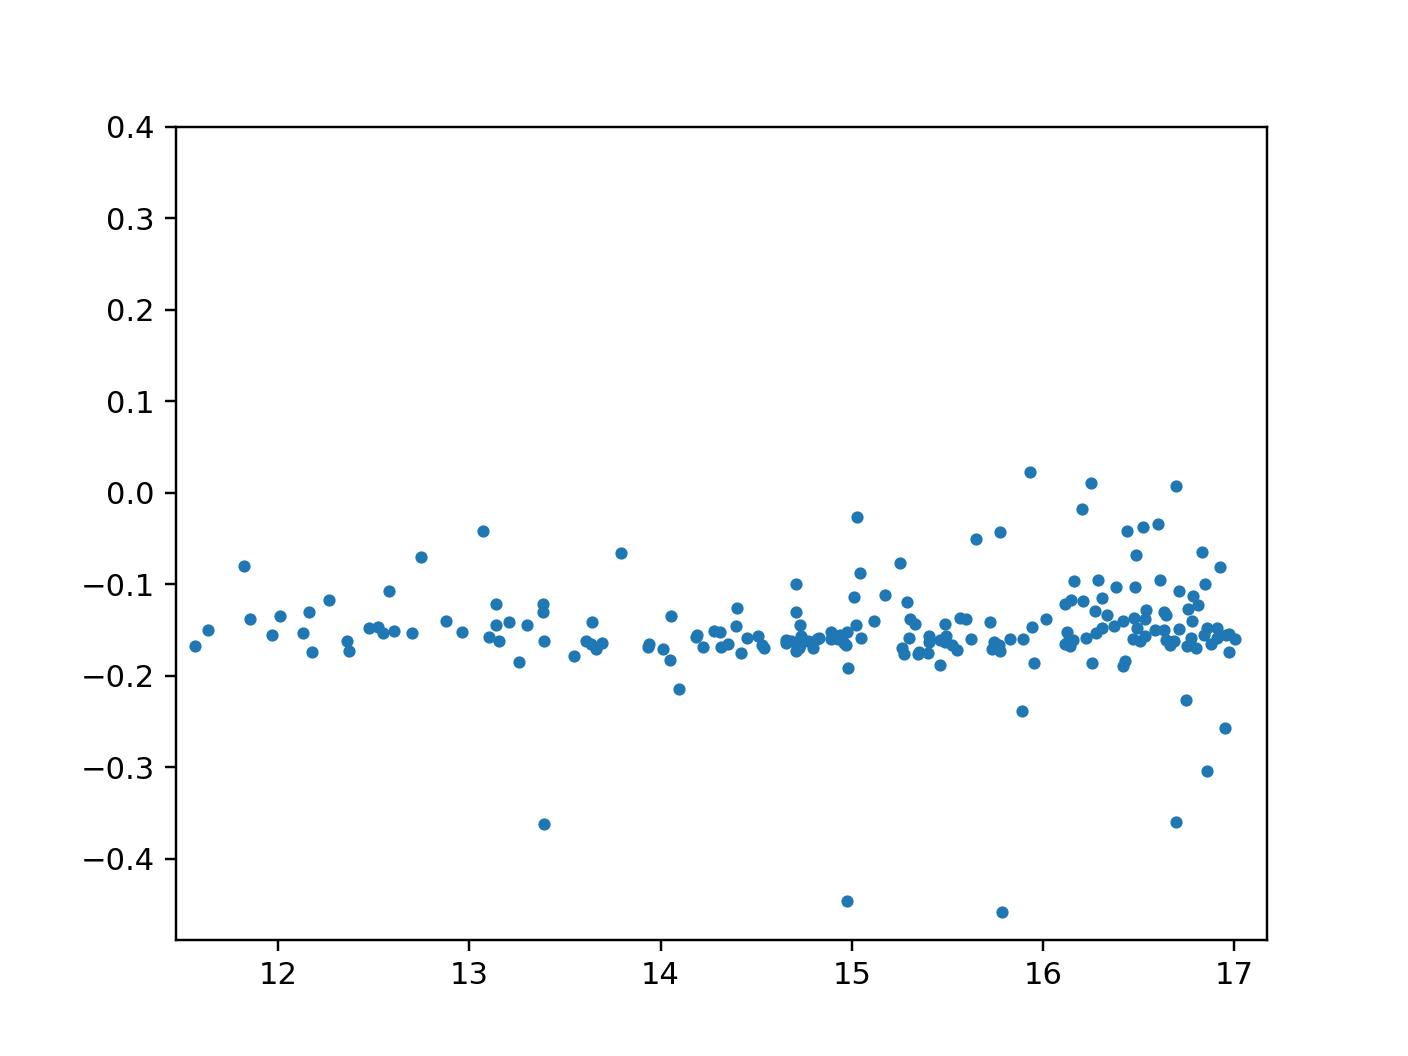

In [278]:
plt.figure()
plt.plot(sub.tmag.values[ind],ncptmag-sub.tmag.values[ind] - fitted_line.parameters[1],'.')


# Paper figs

In [44]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches

<IPython.core.display.Javascript object>


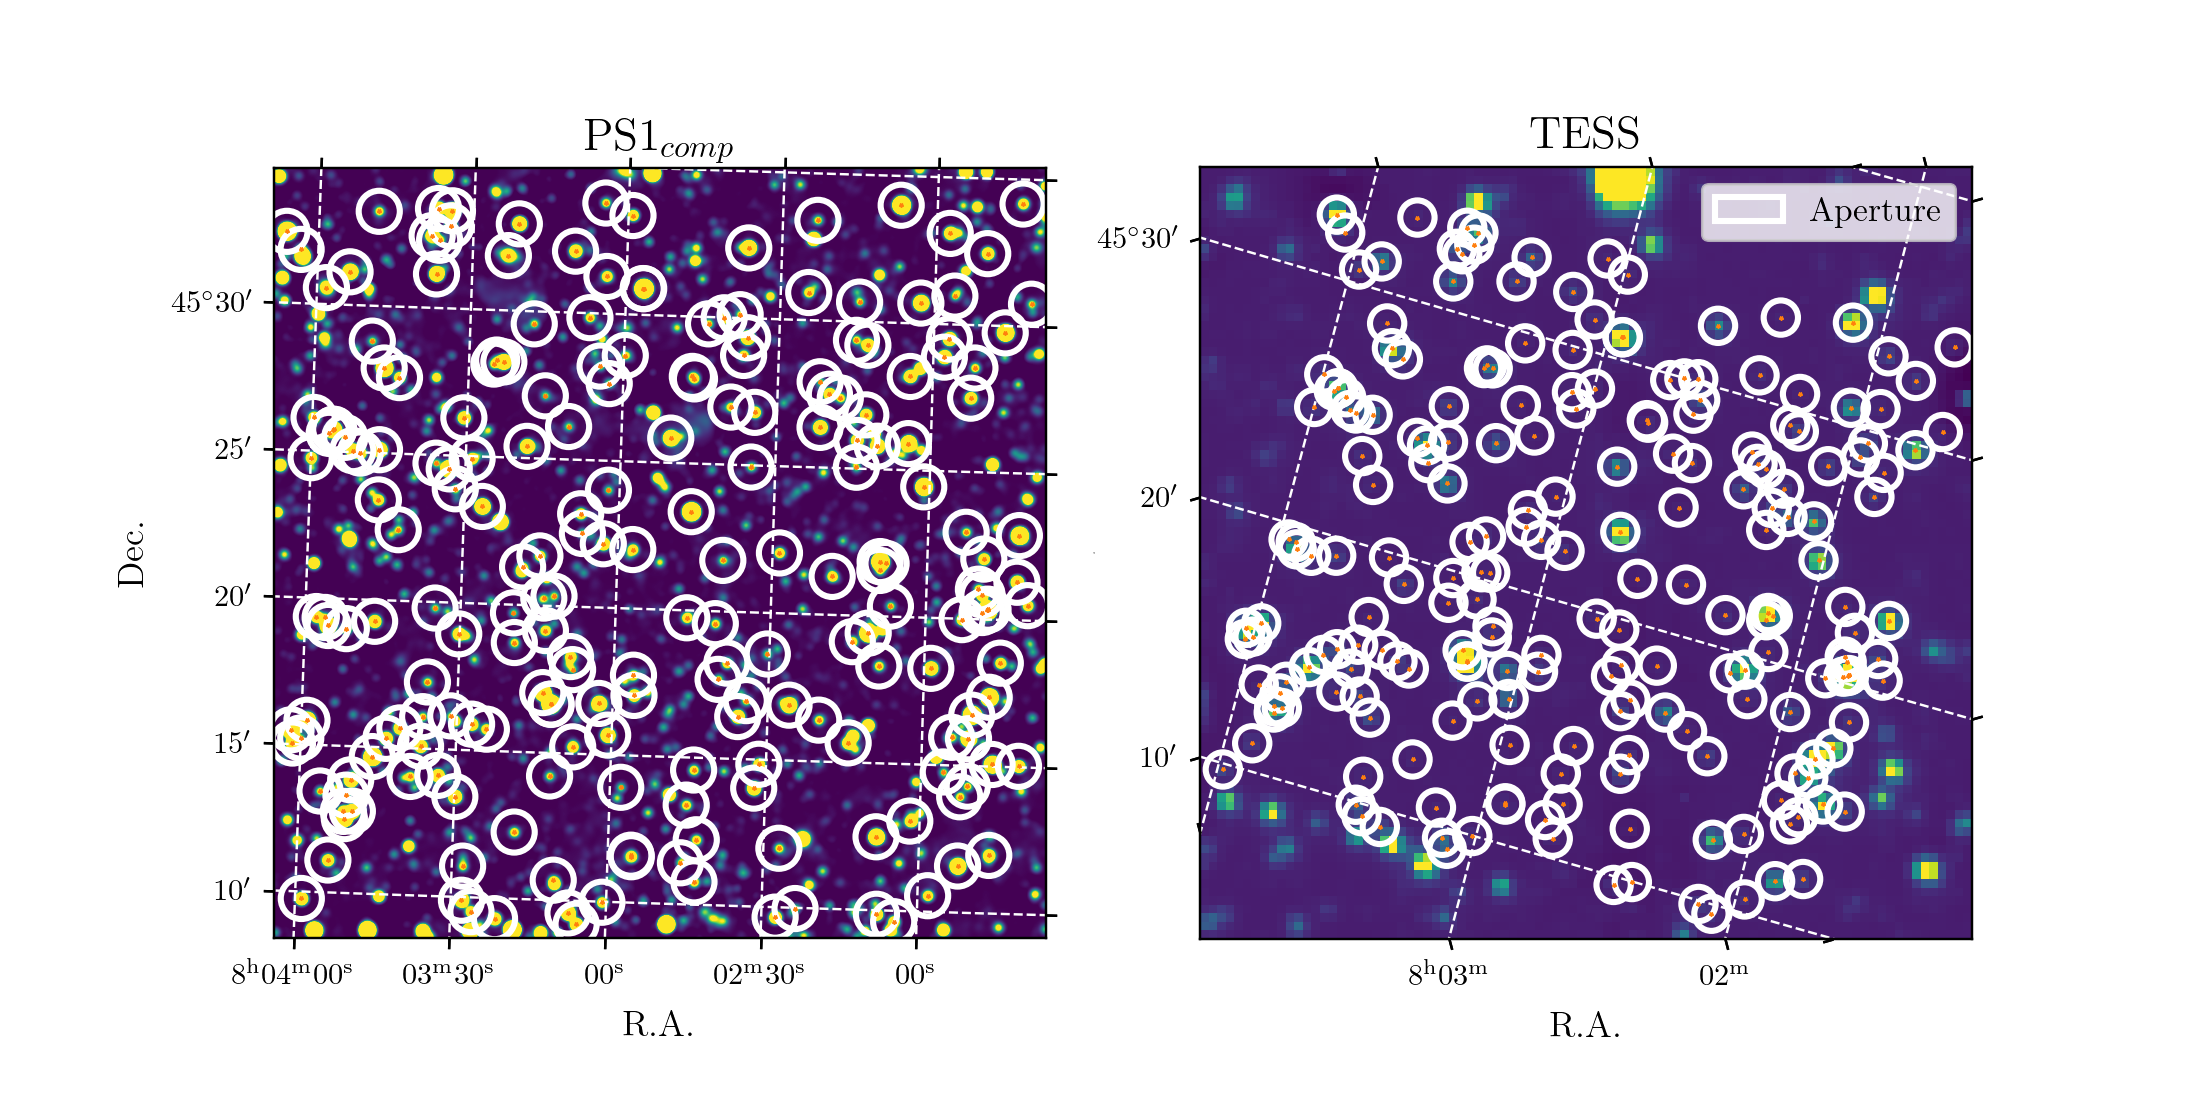

In [64]:
plt.figure(figsize=(2*1.5*fig_width,1.5*fig_width))
plt.subplot(121, projection=wcs)
plt.title(r'PS1$_{comp}$',fontsize=15)
plt.imshow(ps1_tess,vmin=0,vmax=5e2,origin='lower')
plt.plot(sub.ps1x,sub.ps1y,'C1*',ms=1)
ap_patches = paperture.plot(color='white', lw=2,
                           label='Photometry aperture')

plt.xlim(0,ps1_tess.shape[1])
plt.ylim(0,ps1_tess.shape[0])
plt.ylabel('Dec.',fontsize=12)
plt.xlabel('R.A.',fontsize=12)

plt.grid(color='white', ls='--')

plt.subplot(122, projection=tess.wcs)

plt.grid(color='white', ls='--')
plt.title('TESS',fontsize=15)
plt.imshow(tess.ref,vmax=5e2)
plt.plot(sub.tessx,sub.tessy,'C1*',ms=1)
ap_patches = taperture.plot(color='white', lw=2,
                           label='Aperture')

plt.xlabel('R.A.',fontsize=12)
plt.ylabel('a',fontsize=0)
plt.gca().invert_yaxis()
handles = ([ap_patches[0]])
plt.legend(loc=1,
           handles=handles, prop={'weight': 'bold', 'size': 11})

plt.savefig('example_photometry_field.pdf',bbox_inches='tight')

<IPython.core.display.Javascript object>


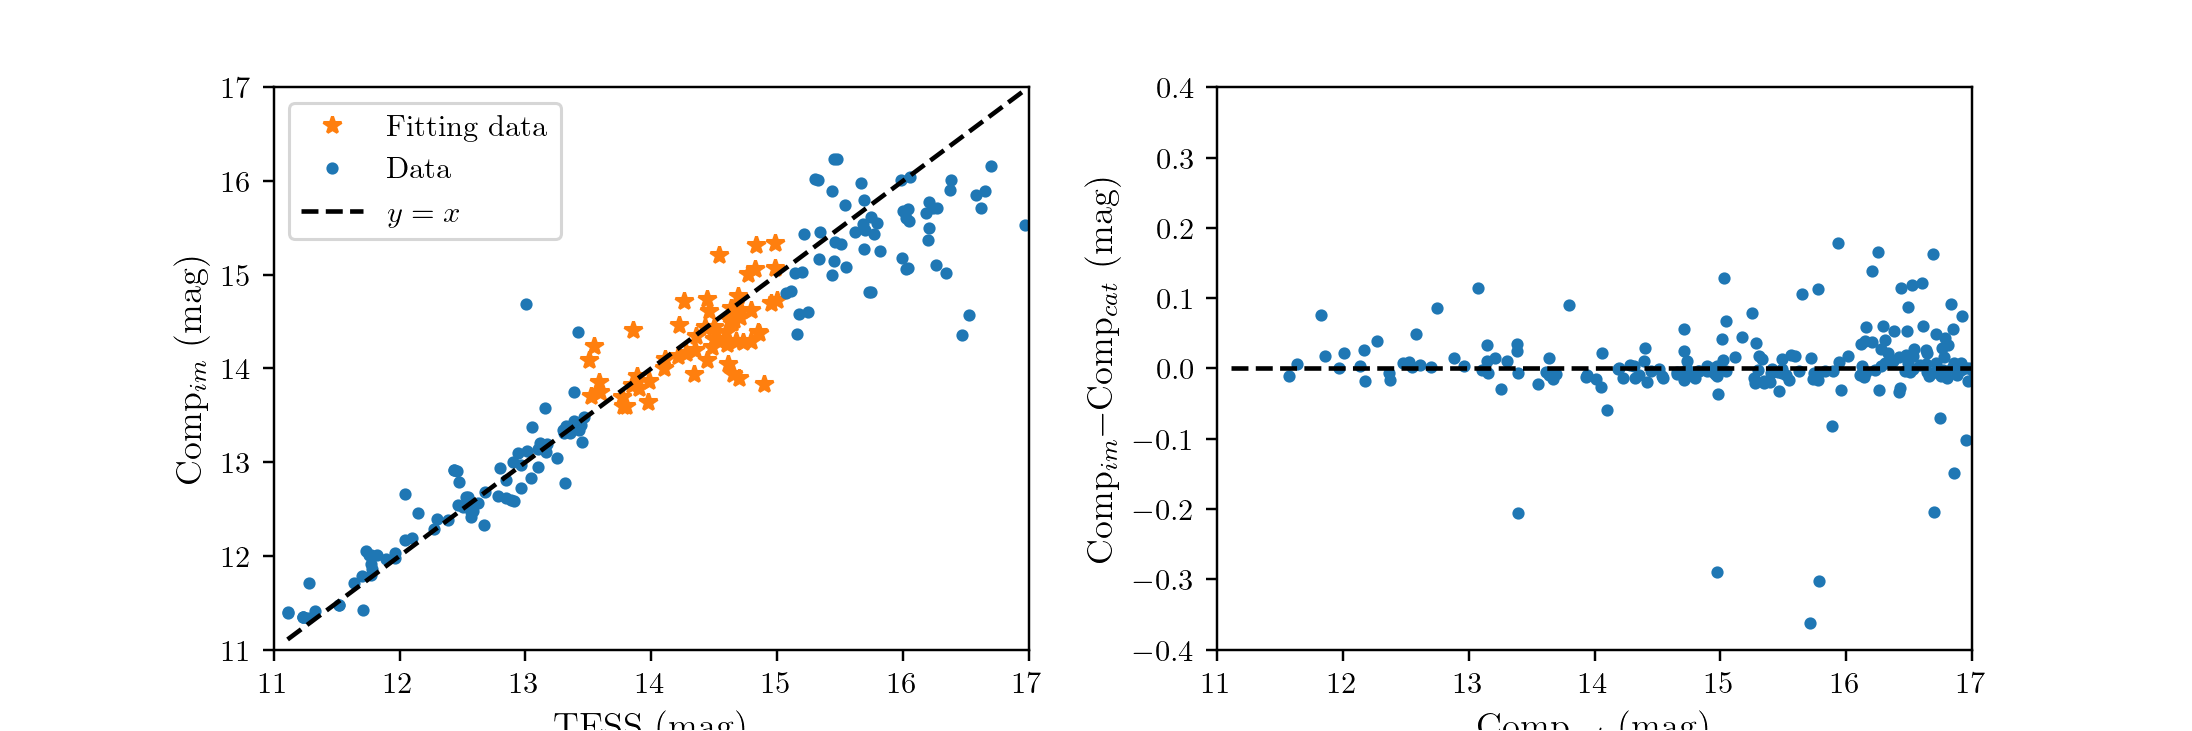

In [92]:
x = np.arange(min(tmag),max(tmag))
plt.figure(figsize=(2*1.5*fig_width,1*fig_width))
plt.subplot(121)
plt.plot(tmag[subsub], filtered_data - fitted_line.parameters[1], "C1*", label="Fitting data")
#plt.plot(tmag, ptmag,"C1o", fillstyle="none", label="Clipped")
plt.plot(tmag[~subsub], ptmag[~subsub] - fitted_line.parameters[1], "C0.", label="Data")
plt.plot(x, fitted_line(x)- fitted_line.parameters[1], 'k--', label=r'$y=x$')
#plt.plot(x,flexi_line(x)- fitted_line.parameters[1],'C1--', label=f'Model, m={np.round(flexi_line.parameters[0],2)}')
plt.xlabel('TESS (mag)',fontsize=12)
#plt.ylabel(r'PS1$_{comp}$ mag',fontsize=12)
plt.ylabel(r'Comp$_{im}$ (mag)',fontsize=12)
plt.xlim(11,17)
plt.ylim(11,17)
plt.legend()

plt.subplot(122)
offset = np.nanmedian(ncptmag - fitted_line.parameters[1] - sub.tmag.values[ind])
plt.plot(sub.tmag.values[ind],ncptmag - fitted_line.parameters[1] - offset- sub.tmag.values[ind],'.')
plt.plot(x, x*0, 'k--', label=r'$y=x$')
#plt.plot(x,flexi_line(x)- fitted_line.parameters[1],'C1--', label=f'Model, m={np.round(flexi_line.parameters[0],2)}')
plt.xlabel(r'Comp$_{cat}$ (mag)',fontsize=12)
plt.ylabel(r'Comp$_{im}-$Comp$_{cat}$ (mag)',fontsize=12)
plt.xlim(11,17)
plt.ylim(-0.4,0.4)
plt.subplots_adjust(wspace=0.25)
plt.savefig('ps1_tess_magcomparison_both.pdf',bbox_inches='tight')


In [93]:
sigma_clipped_stats(ncptmag - fitted_line.parameters[1] - sub.tmag.values[ind])

(-0.14929140277849293, -0.15591373320460988, 0.0272900606050322)

<IPython.core.display.Javascript object>


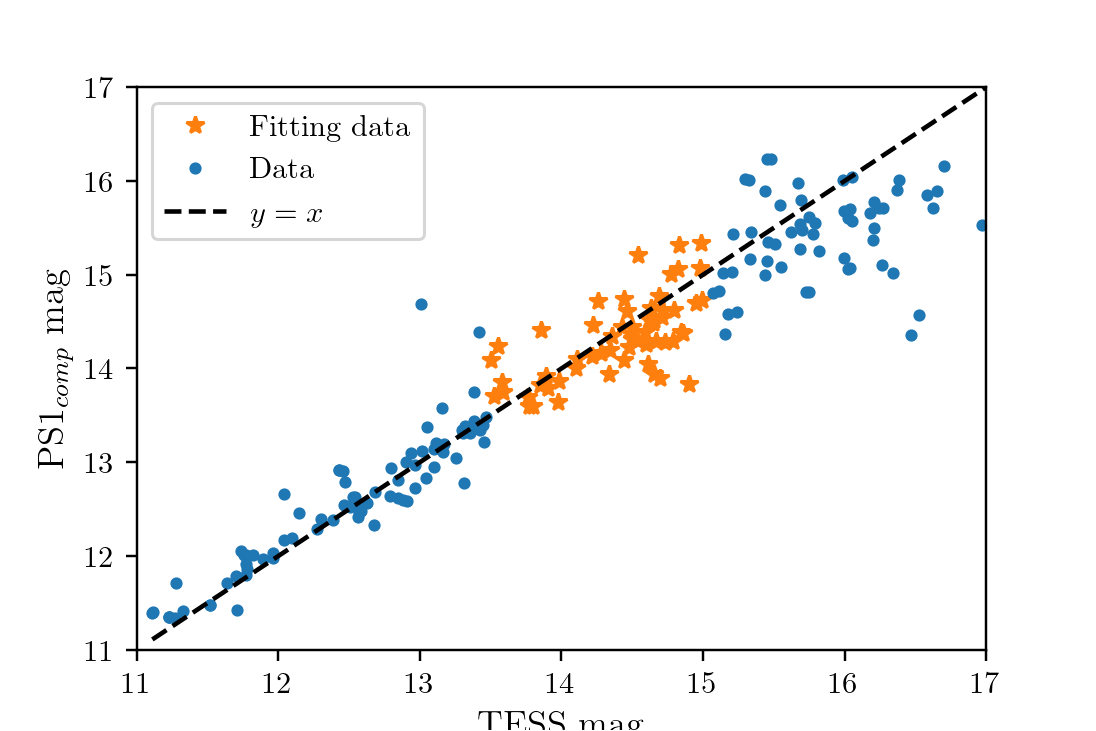

In [66]:
x = np.arange(min(tmag),max(tmag))
plt.figure(figsize=(1.5*fig_width,1*fig_width))
plt.plot(tmag[subsub], filtered_data - fitted_line.parameters[1], "C1*", label="Fitting data")
#plt.plot(tmag, ptmag,"C1o", fillstyle="none", label="Clipped")
plt.plot(tmag[~subsub], ptmag[~subsub] - fitted_line.parameters[1], "C0.", label="Data")
plt.plot(x, fitted_line(x)- fitted_line.parameters[1], 'k--', label=r'$y=x$')
#plt.plot(x,flexi_line(x)- fitted_line.parameters[1],'C1--', label=f'Model, m={np.round(flexi_line.parameters[0],2)}')
plt.xlabel('TESS mag',fontsize=12)
plt.ylabel(r'PS1$_{comp}$ mag',fontsize=12)
plt.xlim(11,17)
plt.ylim(11,17)
plt.legend()
plt.savefig('ps1_tess_magcomparison.pdf',bbox_inches='tight')


In [95]:
sigma_clipped_stats(filtered_data - tmag[subsub])

(-32.68479782139625, -32.71560667168259, 0.34633721397097994)

<IPython.core.display.Javascript object>


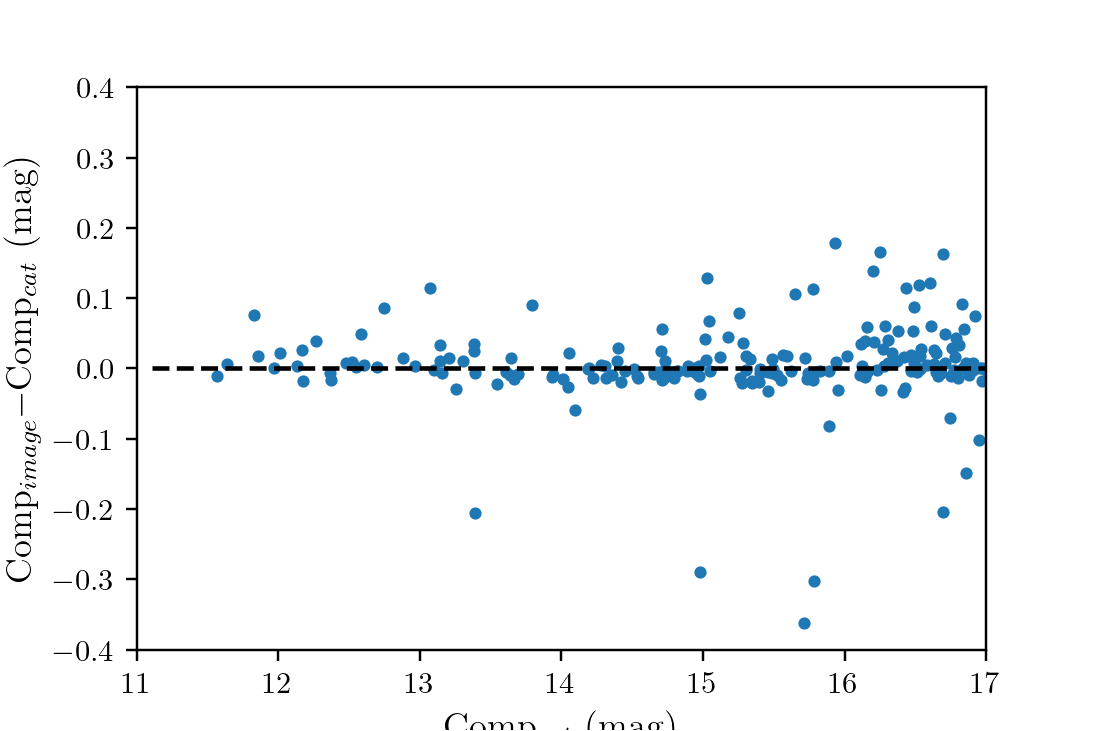

In [84]:
x = np.arange(min(tmag),max(tmag))
offset = np.nanmedian(ncptmag - fitted_line.parameters[1] - sub.tmag.values[ind])
plt.figure(figsize=(1.5*fig_width,1*fig_width))
plt.plot(sub.tmag.values[ind],ncptmag - fitted_line.parameters[1] - offset- sub.tmag.values[ind],'.')
plt.plot(x, x*0, 'k--', label=r'$y=x$')
#plt.plot(x,flexi_line(x)- fitted_line.parameters[1],'C1--', label=f'Model, m={np.round(flexi_line.parameters[0],2)}')
plt.xlabel(r'Comp$_{cat}$ (mag)',fontsize=12)
plt.ylabel(r'Comp$_{image}-$Comp$_{cat}$ (mag)',fontsize=12)
plt.xlim(11,17)
plt.ylim(-0.4,0.4)
#plt.legend()
plt.savefig('ps1comp_to_catalog_comparison.pdf',bbox_inches='tight')


<IPython.core.display.Javascript object>


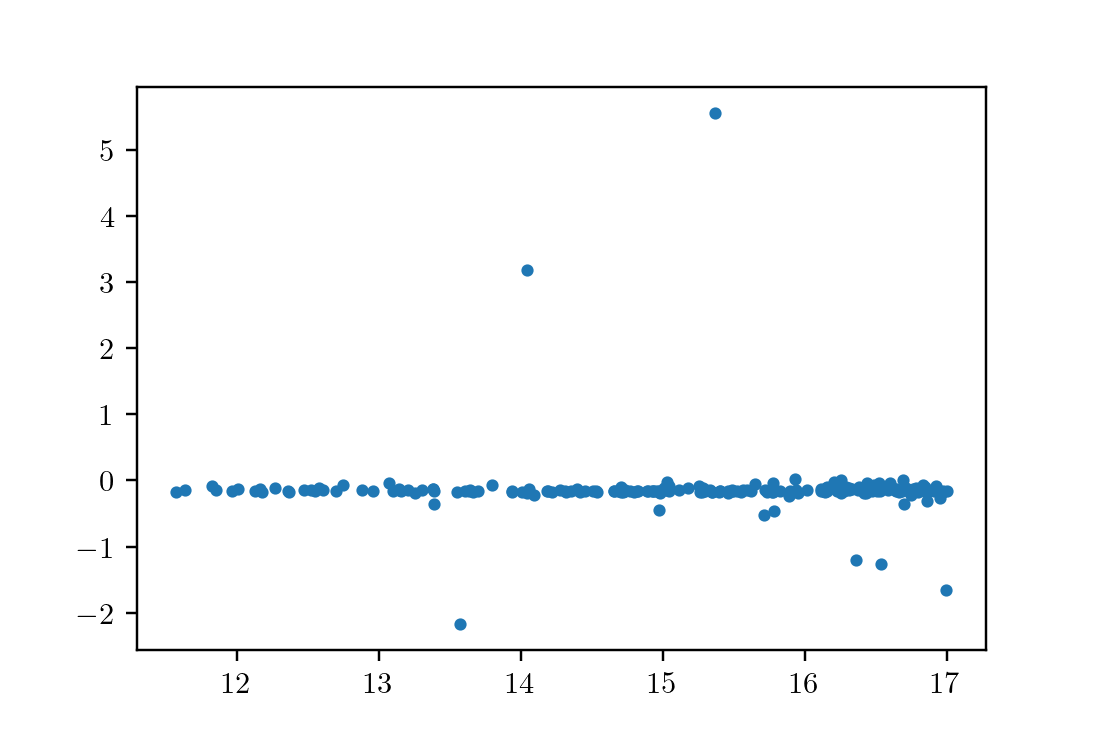

In [67]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
plt.plot(sub.tmag.values[ind],ncptmag-sub.tmag.values[ind] - fitted_line.parameters[1],'.')

In [33]:
max(abs(tess.shift[:,0]))

0.5412092556226383

In [34]:
max(abs(tess.shift[:,1]))

0.5464510066866479

<IPython.core.display.Javascript object>


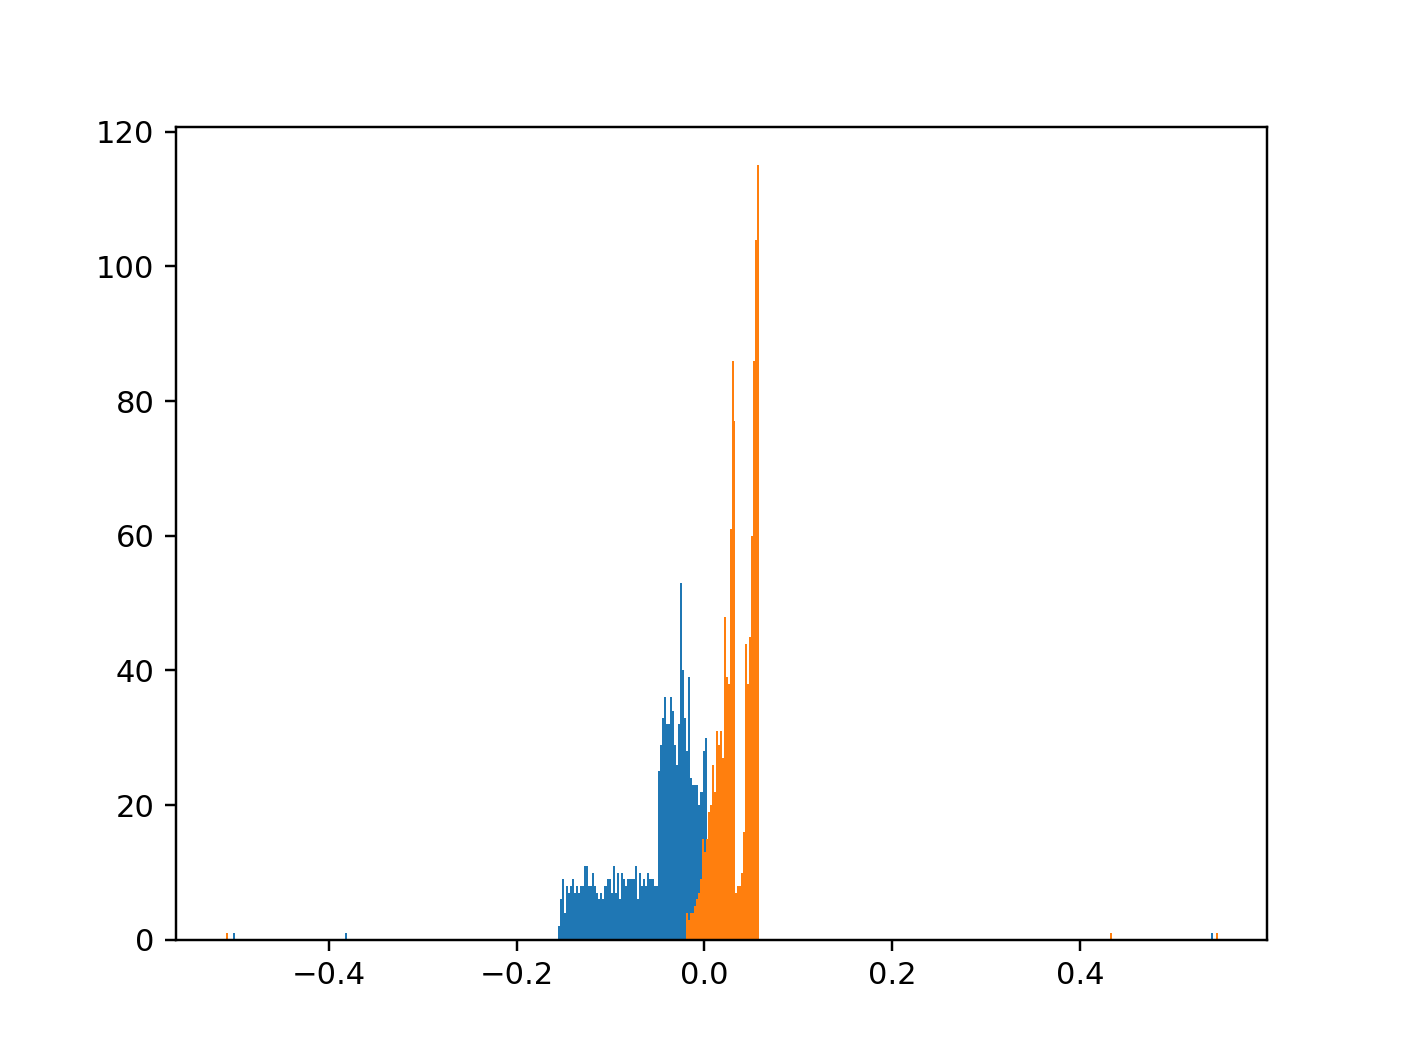

In [37]:
plt.figure()
plt.hist(tess.shift[:,0],bins=500);
plt.hist(tess.shift[:,1],bins=500);

In [41]:
tess.tpf.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 120.72097533459 45.370219977742 
CRPIX : 45.146090951738 45.292661932094 
PC1_1 PC1_2  : -0.0054727311547463 -0.0014407032148012 
PC2_1 PC2_2  : 0.0015867103346302 -0.0055141040970578 
CDELT : 1.0 1.0 
NAXIS : 90  90

<IPython.core.display.Javascript object>


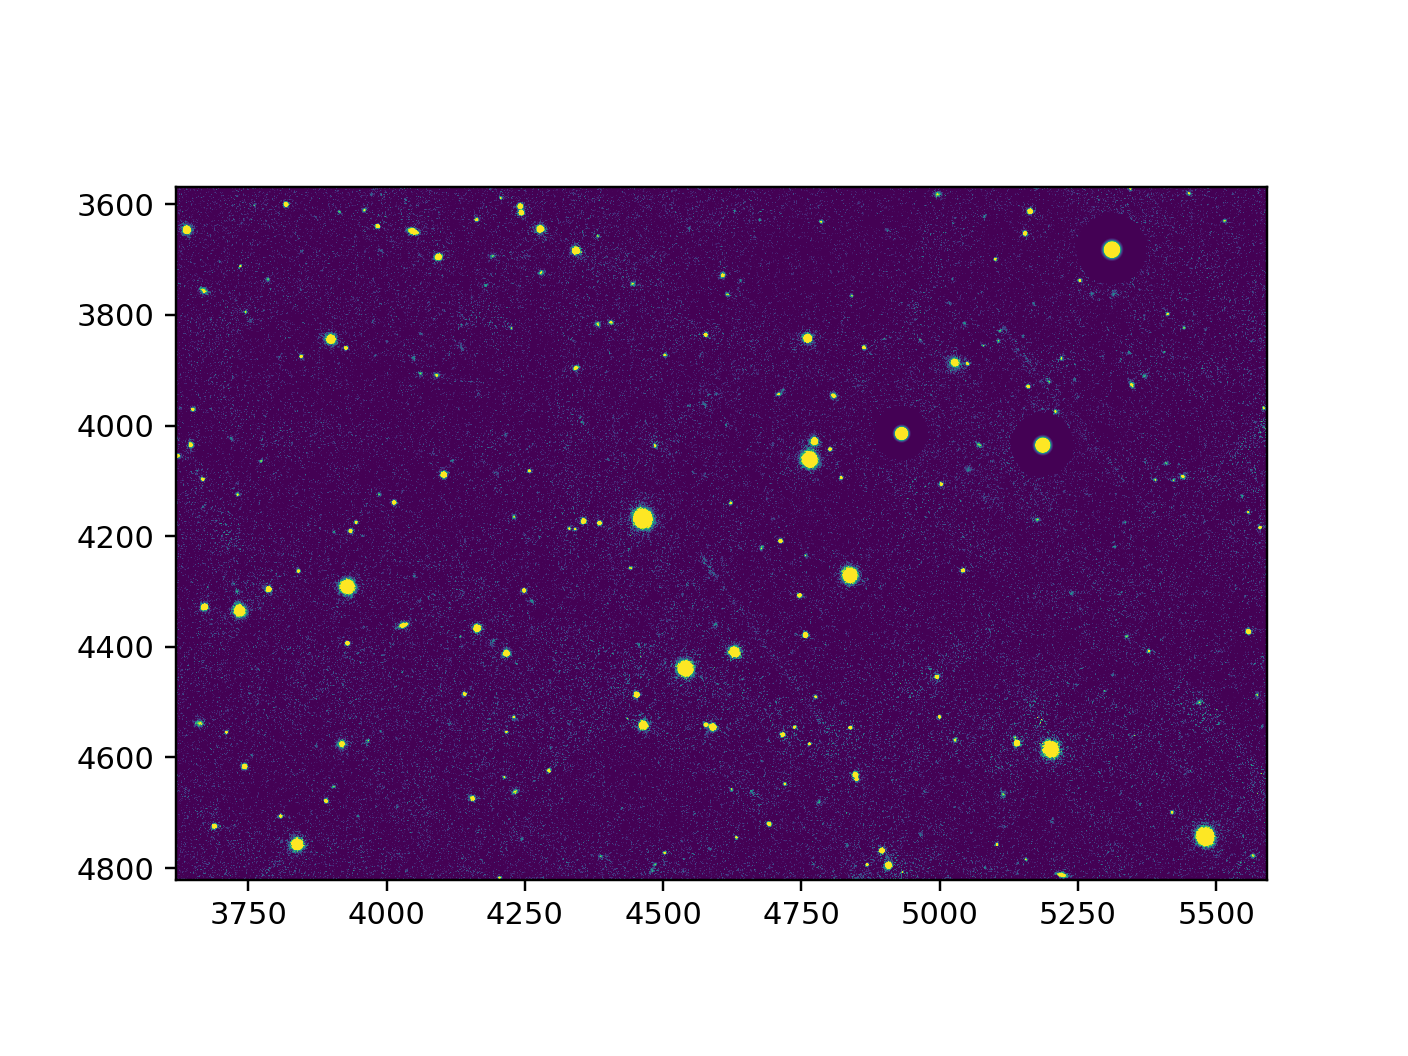

In [54]:
plt.figure()
plt.imshow(data,vmin=100,vmax=1e3)
plt.plot(x,y,'.C1')

<IPython.core.display.Javascript object>


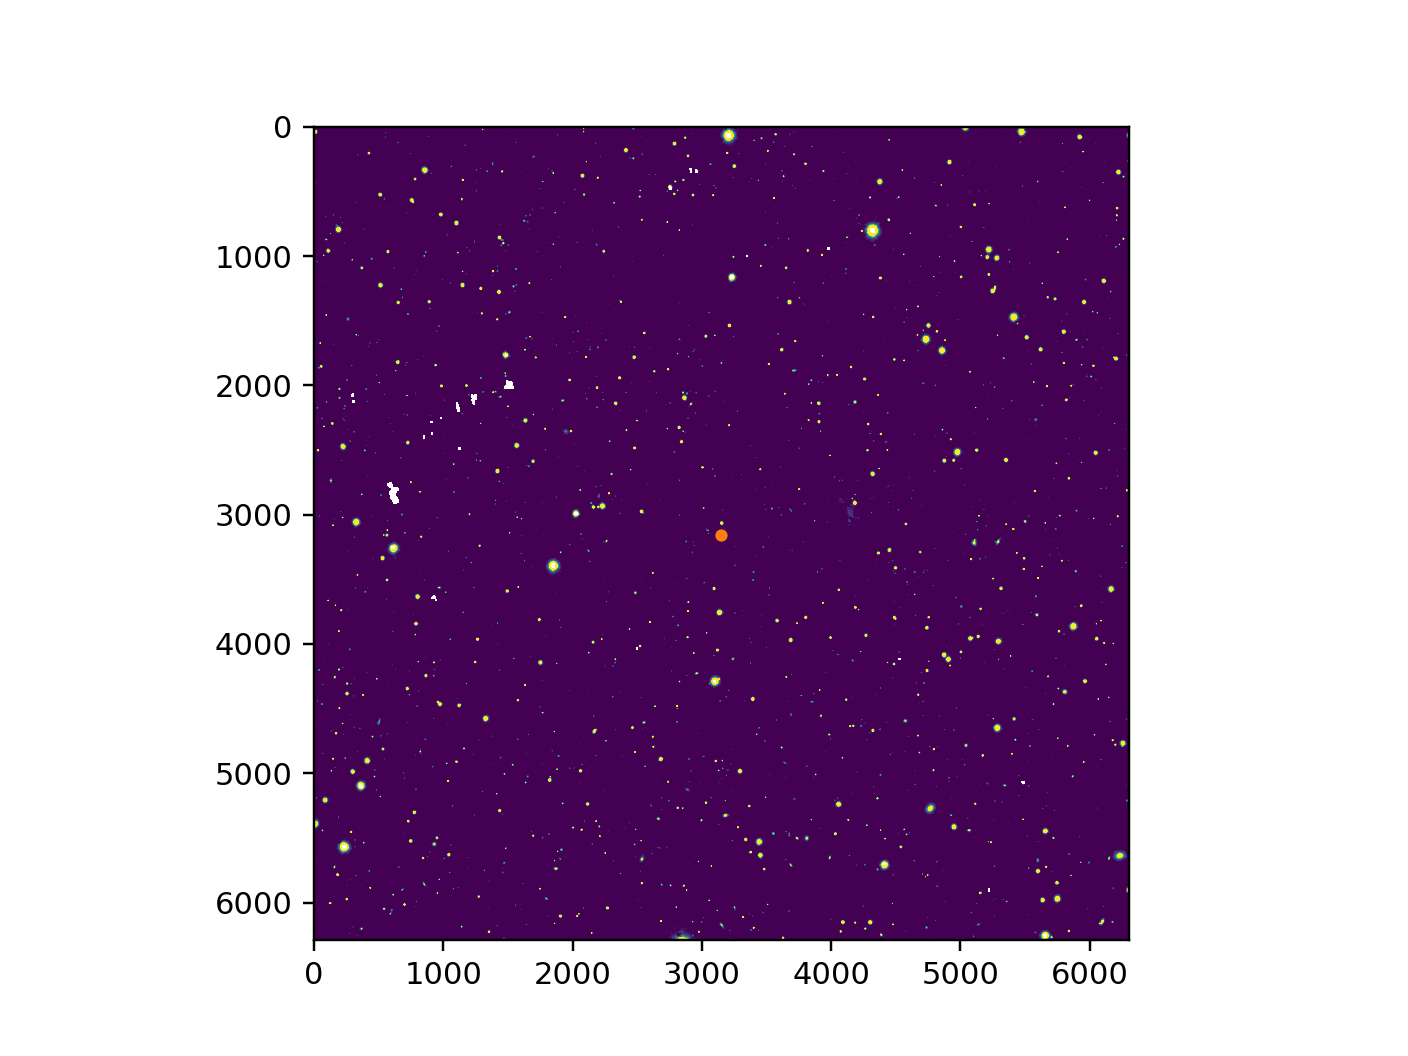

In [28]:
plt.figure()
plt.imshow(data,vmin=100,vmax=1e3)
plt.plot(x,y,'.C1')

In [19]:
tpf = sd.Get_TESS(ra,dec,20)

['data/star_field/rings.v3.skycell.2246.030.stk.r.unconv.fits',
 'data/star_field/rings.v3.skycell.2247.039.stk.r.unconv.fits',
 'data/star_field/rings.v3.skycell.2246.030.stk.z.unconv.fits',
 'data/star_field/rings.v3.skycell.2247.039.stk.y.unconv.fits',
 'data/star_field/rings.v3.skycell.2246.030.stk.i.unconv.fits',
 'data/star_field/rings.v3.skycell.2247.039.stk.i.unconv.fits',
 'data/star_field/rings.v3.skycell.2247.039.stk.z.unconv.fits',
 'data/star_field/rings.v3.skycell.2246.030.stk.y.unconv.fits']

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


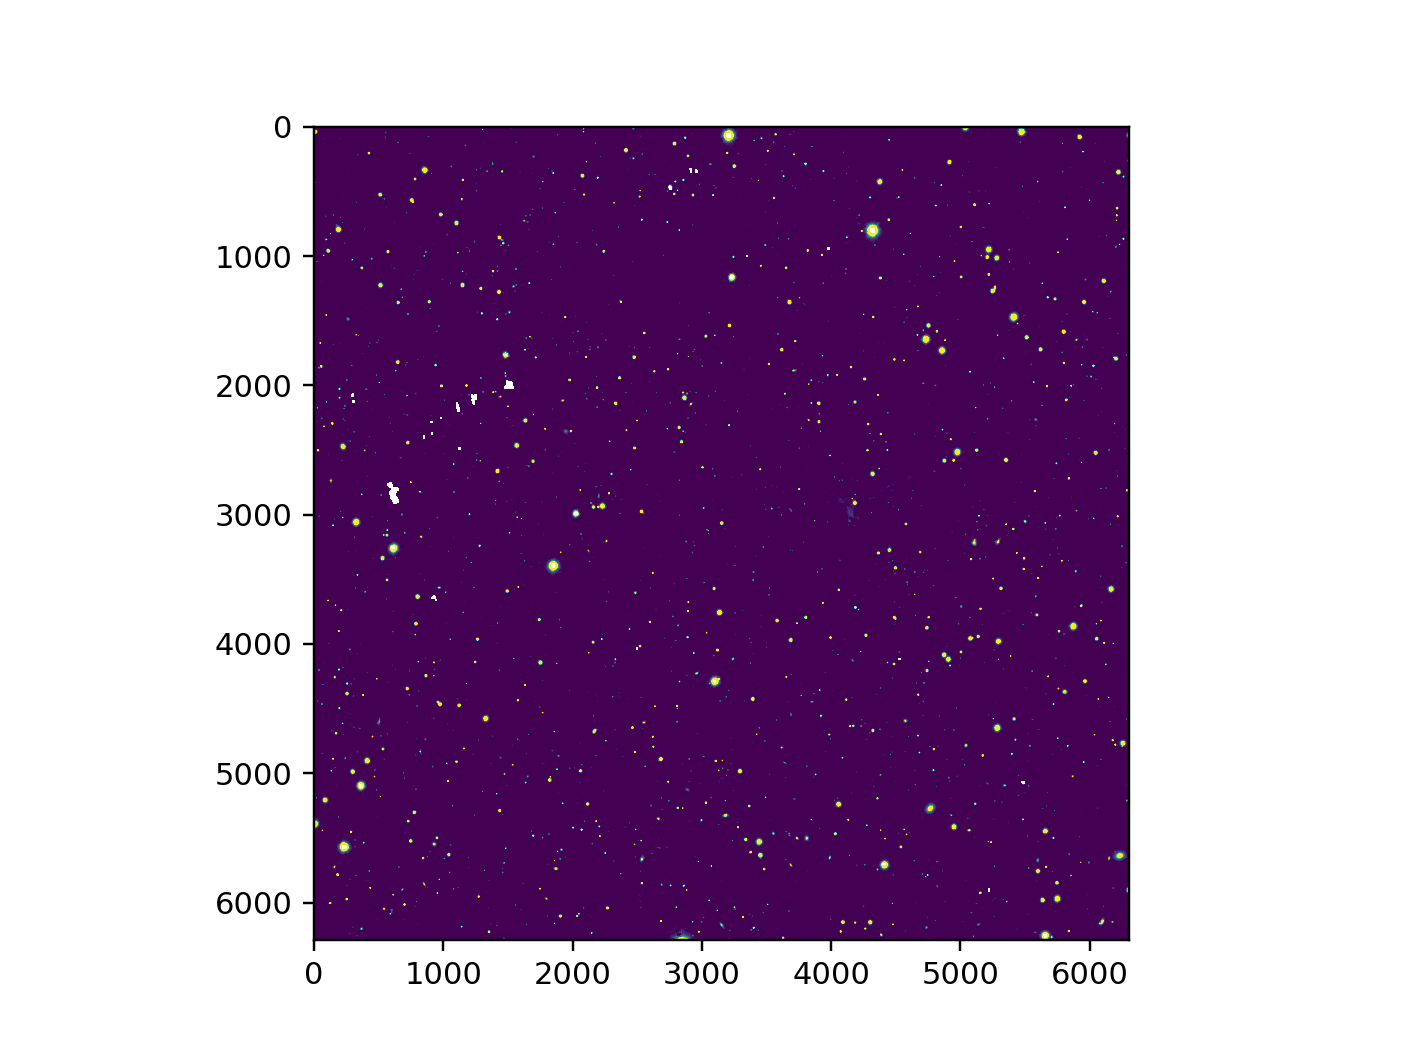

In [ ]:
def test_ps_photom(params,data,psf_shape,aperture,tmag):
    print(params)
    xstd, ystd, theta = params
    y, x = np.mgrid[:psf_shape, :psf_shape]
    x = x-psf.shape[1]/2; y =y- psf.shape[0]/2
    psfg = models.Gaussian2D(x_stddev=xstd,y_stddev=ystd,theta=theta)
    psfg = psfg(x,y)
    psfg /= np.nansum(psfg)
    conv = sd.signal.fftconvolve(data, psfg, mode='same')
    phot_table = aperture_photometry(conv, aperture)
    ptmag = -2.5*np.log10(phot_table['aperture_sum'].value)
    subsub = (tmag >14) & (tmag < 15.5)
    fit = fitting.LinearLSQFitter()
    # initialize the outlier removal fitter
    or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=3.0)
    line_flexi = models.Linear1D(slope=1)
    fl, mask = or_fit(line_flexi, tmag[subsub], ptmag[subsub])
    res = (fl.parameters[0]-1)**2
    print(res)
    return res

x0 = [30,30,0]
psf_shape = psfg.shape[0]
res = minimize(test_ps_photom,x0,args=(noconvps1_tess,psf_shape,paperture[subsub],tmag[subsub]),method='Powell')